{'OAS30001': [['../files/OAS30001_MR_d0129/anat3/sub-OAS30001_sess-d0129_run-02_T1w.nii.gz', '../files/OAS30001_MR_d0129/anat2/sub-OAS30001_sess-d0129_run-01_T1w.nii.gz'], ['../files/OAS30001_MR_d0757/anat3/sub-OAS30001_sess-d0757_run-02_T1w.nii.gz', '../files/OAS30001_MR_d0757/anat2/sub-OAS30001_sess-d0757_run-01_T1w.nii.gz']]}
Path to MNI152 template: '/usr/local/lib/python3.6/site-packages/nilearn/datasets/data/avg152T1_brain.nii.gz'


/usr/local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


asdf
Mask nifti image (3D) is located at (Note this is definitely not a "mast nifti image", was playing around with img.get_data(): [[[12  9  5 ...,  1  1  0]
  [ 9 11 18 ...,  1  1  0]
  [13  7  7 ...,  1  2  0]
  ..., 
  [ 7  3  3 ...,  3  1  0]
  [ 0  4  6 ...,  1  4  0]
  [ 0  0  0 ...,  0  0  0]]

 [[ 6 11  6 ...,  1  0  0]
  [ 5  6  5 ...,  3  1  0]
  [13  3  6 ...,  0  4  0]
  ..., 
  [ 4  7  3 ...,  3  3  0]
  [ 7  4  2 ...,  2  3  0]
  [ 0  0  0 ...,  0  0  0]]

 [[14 14  9 ...,  7  5  0]
  [16  7  2 ...,  3  3  0]
  [15  7 14 ...,  0  1  0]
  ..., 
  [ 1  5  5 ...,  1  1  0]
  [ 3  4  3 ...,  0  1  0]
  [ 0  0  0 ...,  0  0  0]]

 ..., 
 [[13  8  8 ...,  0  2  0]
  [12 16 14 ...,  3  3  0]
  [17 13 15 ...,  1  4  0]
  ..., 
  [ 4  8 14 ...,  3  4  0]
  [ 6 10  2 ...,  2  2  0]
  [ 0  0  0 ...,  0  0  0]]

 [[ 3 36  7 ...,  2  6  0]
  [23  8 21 ...,  2  1  0]
  [ 8 12 23 ...,  2  4  0]
  ..., 
  [ 8  0  4 ...,  1  0  0]
  [10  1  3 ...,  1  0  0]
  [ 0  0  0 ...,  0  0  0]]

 

/usr/local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


zoam


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:278: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


ValueError: Found input variables with inconsistent numbers of samples: [6217, 5746]

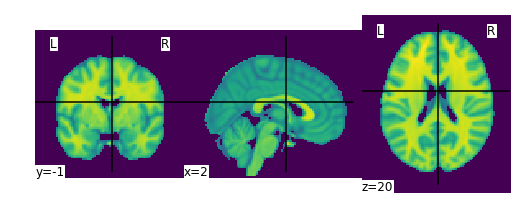

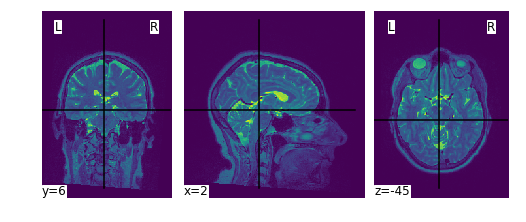

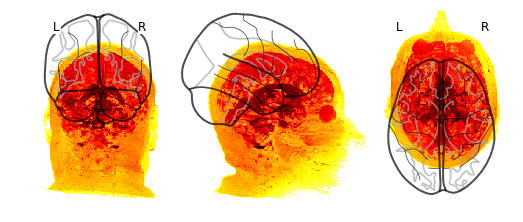

In [2]:
import os
import numpy as np
import nibabel as nib
import configparser
import json
import csv
from nilearn import plotting
from enum import Enum, auto
import re



# parse in config to see where to read the files in from

DementiaStrings = ["AD dem/FLD prior to AD dem", 
                    "AD dem w/depresss  not contribut", 
                    "AD dem w/depresss- not contribut", 
                    "AD dem w/Frontal lobe/demt at onset", 
                    "Incipient demt PTP", 
                    "AD dem w/oth (list B) not contrib", 
                    "AD dem distrubed social- prior", 
                    "Vascular Demt  primary", 
                    "AD dem Language dysf with", 
                    "AD dem distrubed social- with", 
                    "DAT", 
                    "DLBD- secondary", 
                    "DAT w/depresss not contribut", 
                    "Frontotemporal demt. prim", 
                    "AD dem Language dysf after", 
                    "AD dem w/CVD not contrib", 
                    "AD dem w/oth unusual features", 
                    "AD dem w/PDI after AD dem not contrib", 
                    "AD dem w/oth (list B) contribut", 
                    "AD dem cannot be primary", 
                    "AD dem Language dysf prior", 
                    "AD dem visuospatial- prior", 
                    "AD dem w/oth unusual features/demt on", 
                    "AD dem w/depresss- contribut", 
                    "AD dem w/CVD contribut", 
                    "AD dem visuospatial- with", 
                    "DLBD- primary", 
                    "Incipient Non-AD dem", 
                    "Dementia/PD- primary", 
                    "AD dem distrubed social- after", 
                    "Vascular Demt- secondary", 
                    "AD dem w/depresss  contribut", 
                    "AD Dementia", 
                    "AD dem w/PDI after AD dem contribut", 
                    "AD dem w/oth unusual feat/subs demt", 
                    "Vascular Demt- primary"]
NoDementiaStrings = ["ProAph w/o dement", 
                        "Non AD dem- Other primary", 
                        "Cognitively normal", 
                        "No dementia"]
class Dementia(Enum):
    DEMENTIA = "Dementia"
    NO_DEMENTIA = "No_Dementia"
    UNKNOWN = "Unknown"

    @staticmethod
    def from_str(string):
        if string in DementiaStrings:
            return Dementia.DEMENTIA
        elif string in NoDementiaStrings:
            return Dementia.NO_DEMENTIA
        return Dementia.UNKNOWN


patient_results = {}
with open('../patient_diagnosis.csv') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)
    for row in reader:
        rowObj = {}
        for h, v in zip(headers, row):
            rowObj[h] = v
        if rowObj['Subject'] not in patient_results:
            patient_results[rowObj['Subject']] = []
        patient_results[rowObj['Subject']].append(rowObj)

patient_id_to_results = {}
for subject, subjectData in patient_results.items():
    for data in subjectData:
        if data['dx1'] is '':
            continue
        if subject not in patient_id_to_results:
            patient_id_to_results[subject] = [Dementia.from_str(data['dx1'])]
        else:
            patient_id_to_results[subject].append(Dementia.from_str(data['dx1']))


for subject, data in patient_id_to_results.items():
    if len(data) is 1:
        patient_id_to_results[subject] = data[0]
    elif len(data) > 1 and len(set(data)) != 1:
        if Dementia.DEMENTIA in data:
            patient_id_to_results[subject] = Dementia.DEMENTIA
        elif Dementia.NO_DEMENTIA in data:
            patient_id_to_results[subject] = Dementia.NO_DEMENTIA
        else:
            patient_id_to_results[subject] = Dementia.UNKNOWN
    else:
        patient_id_to_results[subject] = data[0]


config = configparser.ConfigParser()
config.read('../config.ini')
location = config['FILES']['Location']

# find all the files in the folder
raw_scan_ids = [x for x in os.listdir(location)]
if '.DS_Store' in raw_scan_ids: raw_scan_ids.remove('.DS_Store')

id_extractor_pattern = re.compile('(.*?)_')

labelled_scan_ids = []

for raw_scan_id in raw_scan_ids:
    m = id_extractor_pattern.match(raw_scan_id)
    scan_id = m.group(1)
    if scan_id not in patient_id_to_results:
        continue
    elif patient_id_to_results[scan_id] is Dementia.UNKNOWN:
        continue
    labelled_scan_ids.append((scan_id, raw_scan_id))

FLAG = "T1w" #or T2w
mri_extractor_pattern = re.compile('anat[0-9]*')

if FLAG is "T1w":
    mri_type_pattern = re.compile(".*T1w.nii.gz")
else:
    mri_type_pattern = re.compile(".*T2w.nii.gz")

paths = {}


for scan_id, raw_scan_id in labelled_scan_ids:
    raw_scan_id = location + "/" + raw_scan_id
    scans = [x for x in os.listdir(raw_scan_id) if mri_extractor_pattern.match(x)]
    scanLocations = []
    for scan in scans:
        scan_folder = raw_scan_id + "/" + scan
        scanTypeMatch = [x for x in os.listdir(scan_folder) if mri_type_pattern.match(x)]
        if scanTypeMatch:
            scanLocations.append(scan_folder + "/" + scanTypeMatch[0])
    if scan_id not in paths:
        paths[scan_id] = []
    paths[scan_id].append(scanLocations)
print(paths)
    
# so the paths are ordered in a list like array, and idea is to take each index of list or
# each file and feed .nii file to sci kit learn somehow. 

#after including plotting, attempt to plot the image? 

#attempting to use niilearn
#from nibabel.testing import data_path 
#path it gave me was :'/Users/justinchang/anaconda3/lib/python3.6/site-packages/nibabel/tests/data/test.nii'
#dont quite understand why i cant open it that way... 

%matplotlib inline

from nilearn import image

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

# Note that the variable MNI152_FILE_PATH is just a path to a Nifti file
print('Path to MNI152 template: %r' % MNI152_FILE_PATH)
%matplotlib inline
plotting.plot_img(MNI152_FILE_PATH)

plotting.plot_img("../files/OAS30001_MR_d0129/anat4/sub-OAS30001_sess-d0129_T2w.nii.gz")
plotting.plot_glass_brain("../files/OAS30001_MR_d0129/anat4/sub-OAS30001_sess-d0129_T2w.nii.gz")  
#example_filename = os.path.join(data_path, 'test.nii')
#img = nib.load(example_filename)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



import os
import numpy as np
#from nibabel.testing import paths

"""

Decoding with ANOVA + SVM: face vs house in the Haxby dataset
===============================================================

This example does a simple but efficient decoding on the Haxby dataset:
using a feature selection, followed by an SVM.

"""

#############################################################################
# Retrieve the files of the Haxby dataset
# ----------------------------------------
#from nilearn import datasets

# By default 2nd subject will be fetched
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()
from sklearn.svm import SVC
svc = SVC(kernel='linear', C=1.)

#example_filename = "../files/OAS30001_MR_d0129/anat4/test.nii"#paths["OAS30001"] #feels bad cant evn hardcode a single path from the paths dict LOL
import nibabel as nib 




for personId, MRISession in paths.items():
    print('asdf')
    for MRI in sorted(MRISession):
        for scan in sorted(MRI):
            img = nib.load(scan)
            print('Mask nifti image (3D) is located at (Note this is definitely not a "mast nifti image", was playing around with img.get_data(): %s' % img.get_data())
            print(scan) #this is the actual location of the data
        pass

# print basic information on the dataset


#svc.fit(data[:-10], labels[:-10])   



import pandas as pd

# Load target information as string and give a numerical identifier to each


behavioral = pd.read_csv("../patient_diagnosis.csv")
conditions = behavioral['Label']

# Restrict the analysis to faces and places
condition_mask = behavioral['dx1'].isin(['AD Dementia', 'Frontotemporal demt. prim','Cognitively normal','DLBD- primary','uncertain dementia'])
conditions = conditions[condition_mask]

# We now have 4 conditions
print(conditions.unique())
session = behavioral[condition_mask]



from nilearn.input_data import NiftiMasker

#file_name is a nii.gz
# mask_filename = "../files/OAS30001_MR_d0129/anat4/sub-OAS30001_sess-d0129_T2w.nii.gz"

# For decoding, standardizing is often very important
# note that we are also smoothing the data
masker = NiftiMasker(mask_img=haxby_dataset.mask, smoothing_fwhm=4,
                     standardize=True, memory="nilearn_cache", memory_level=1)

#hard coded a filename for now
func_filename = "../files/OAS30001_MR_d0129/func1/sub-OAS30001_sess-d0129_task-rest_run-01_bold.nii.gz"
#getting a mask is not 2 values error wtf does that mean 
print("moaz")
print(func_filename)
X = masker.fit_transform(func_filename)
print("zoam")
# Apply our condition_mask  

X = X[condition_mask]


from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 5% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=5)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

#fit decoder, predict
anova_svc.fit(X, conditions)
y_pred = anova_svc.predict(X)


#obtaining score / accuracy via cross validation 

from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneLabelOut cross-validation on the session label
# which corresponds to a leave-one-session-out
cv = LeaveOneLabelOut(session['memory'])

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X, conditions, cv=cv)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(conditions.unique())))
# Classification accuracy:   / Chance level: 